In [1]:
# quick config edit:
Configuration_Name = "kick_trend"
Simulation_Name = "sim"
Initial_Bit_Depth = 2500

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import openlab
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from IPython.display import display, clear_output
from scipy.signal import savgol_filter


import warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated")

%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%reload_ext autoreload


In [3]:
%store -r selected_features
%store -r target_col
%store -r input_timesteps
%store -r num_features
%store -r scaler_2
%store -r fit_columns
%store -r tags

# model = load_model("simplified_model.h5")

tags = ['SPP', 'DownholeECD', 'FlowRateOut', 'HookLoad', 'BitDepth', 'TD', 'DownholePressure', 'FluidTemperatureOut', 'WOB', 'InstantaneousROP', 'FlowRateIn', 'TopOfStringVelocity', 'SurfaceRPM', 'CalculatedPressureBottomHole', 'FluidTemperatureIn', 'TotalMudLossMass', 'Connection', 'TopOfStringPosition', 'ActivePitVolume', 'ActivePitDensity', 'ActivePitTemperature', 'MainPitVolume', 'MainPitDensity', 'MainPitTemperature', 'ReservePitVolume', 'ReservePitDensity', 'ReservePitTemperature']

In [4]:
username="ax.jorgensen@stud.uis.no"
apikey="EDE1872A07785D868992DEBB642A81C2DB726ECCA6E0DF115A44E43C6248AE8A"
licenseguid="c3a0315b-813c-4e0b-8ec9-e14436a1783d"

In [5]:
session = openlab.http_client(username=username, apikey=apikey, licenseguid=licenseguid)

14:28:07 [INFO] Initializing Openlab http client
14:28:07 [INFO] Creating token
14:28:08 [INFO] Saving token
14:28:08 [INFO] Login Succesfull


In [6]:
config_name = Configuration_Name
sim_name = Simulation_Name
initial_depth = Initial_Bit_Depth

In [7]:
influx_mode = openlab.default_manual_influx

In [8]:
manual_influx_loss_mass_rate = random.randint(0, 3500) / 60
manual_influx_loss_total_mass = random.randint(0, 3500)

sim_trend = session.create_simulation(
    config_name, sim_name, 
    initial_depth, 
    influx_mode=influx_mode, 
    ComplexReservoirKickOffTime= 80, 
    Id="ManualInflux", 
    ManualInfluxLossMD=random.randint(2501, 2504), 
    ManualInfluxLossMassRate=manual_influx_loss_mass_rate, #Max = 4999 kg/min
    ManualInfluxLossTotalMass=manual_influx_loss_total_mass, #Max = 5000 kg
    ManualReservoirMode=True, 
    UseReservoirModel=True
)

14:28:08 [INFO] User limits: {'ActiveSimulationCount': 0, 'MaxConcurrentSimulations': 5, 'MaxSimulationCount': 0, 'MaxStepCount': 180000, 'MaxStoredSimulations': 10, 'MaxTimeStep': 18000, 'TotalSimulationCount': 2560, 'UsedCapacityPercent': 1, 'UsedStepCount': 1221}
14:28:08 [INFO] ManualInflux selected
14:28:24 [INFO] Simulation Initialized


In [9]:
sim_trend.setpoints.SurfaceRPM = 2 #HZ
sim_trend.setpoints.TopOfStringVelocity = 0.02 #m/s
sim_trend.setpoints.DesiredROP = 0.02 #m/s
sim_trend.setpoints.FlowRateIn = 2500/60000 #converting l/min to m^3/s

In [10]:
###############################################

In [11]:
%store -r selected_features
%store -r target_col
%store -r input_timesteps
%store -r num_features
%store -r scaler_2
%store -r fit_columns
%store -r tags

In [12]:
def check_anomaly(df, target_col, optional_col, threshold=0.05, window=10, annotations=None, count_dict=None):
    if count_dict is None:
        count_dict = {target_col: 0, optional_col: 0}

    target_values = df[target_col].tail(window + 1)
    optional_values = df[optional_col].tail(window + 1) if optional_col in df.columns else None

    target_pct_change = target_values.pct_change().iloc[-window:]
    optional_pct_change = optional_values.pct_change().iloc[-window:] if optional_values is not None else None

    columns_to_check = [target_col]
    if optional_values is not None:
        columns_to_check.append(optional_col)

    kick_detected = False
    for col in columns_to_check:
        if col == target_col:
            pct_change = target_pct_change
        else:
            pct_change = optional_pct_change

        if (pct_change.abs() > threshold).any():
            if count_dict[col] == 0:
                text = f"An anomaly has been detected for {col} (average percentage change: {pct_change.abs().mean():.2%}), do you want to continue?"
                user_input = input(text)
                if user_input.lower() not in ['y', 'yes']:
                    raise Exception("User chose to stop program.")

                x_pos = df.tail(1)['timeStep'].iloc[0]
                y_pos = df.tail(1)[col].iloc[0]
                annotations[col] = (x_pos, y_pos)

                kick_detected = True
                count_dict[col] += 1
            elif count_dict[col] >= 1 and count_dict[col] < 10:
                kick_detected = True
                count_dict[col] += 1
            elif count_dict[col] == 10:
                count_dict[col] = 0
        else:
            kick_detected = False
            count_dict[col] = 0

    return kick_detected, annotations, count_dict


In [13]:
# Receive values from simulator, this is the first function in the loop
def get_values_at_timestep(sim_trend, tags, timeStep):
    values = {}
    for feature in tags:
        # Skip "Connection" feature
        if feature == "Connection":
            continue
        # Create the variable name for the current feature
        var_name = f"{feature}"
        # Extract the value of the feature at this time step
        value_dict = eval(f"sim_trend.results.{var_name}")
        value = list(value_dict.values())[-1]  # Extract the value as a number
        # Add the value to the dictionary
        values[feature] = value
    values['timeStep'] = timeStep  # can be left in or out depending on model
    return values

In [14]:
def update_local_extrema(derivative_target_col, derivative_optional_col, unscaled_df,
                         target_col, timeStep, local_maxima_target_col, local_minima_target_col, last_derivative_target_col, realtimespan_target_col,
                         optional_col, local_maxima_optional_col, local_minima_optional_col, last_derivative_optional_col, realtimespan_optional_col):
    
    if np.sign(derivative_target_col[-1]) != np.sign(derivative_target_col[-2]):
        
        if np.sign(derivative_target_col[-2]) == -1:
            
            local_maxima_target_col.append((timeStep - 1, unscaled_df[target_col].iloc[-2]))
            
            last_derivative_target_col = 1
            
            realtimespan_target_col.clear()
            
            realtimespan_target_col.append(timeStep)
            
        elif np.sign(derivative_target_col[-2]) == 1:
            
            local_minima_target_col.append((timeStep - 1, unscaled_df[target_col].iloc[-2]))
            
            last_derivative_target_col = 0
            
            realtimespan_target_col.clear()
            
            realtimespan_target_col.append(timeStep)
            
    
    # Optional_col
    
    if np.sign(derivative_optional_col[-1]) != np.sign(derivative_optional_col[-2]):
        
        if np.sign(derivative_optional_col[-2]) == -1:
            
            local_maxima_optional_col.append((timeStep - 1, unscaled_df[optional_col].iloc[-2]))
            
            last_derivative_optional_col = 1
            
            realtimespan_optional_col.clear()
            
            realtimespan_optional_col.append(timeStep)
            
        elif np.sign(derivative_optional_col[-2]) == 1:
            
            local_minima_optional_col.append((timeStep - 1, unscaled_df[optional_col].iloc[-2]))
            
            last_derivative_optional_col = 0
            
            realtimespan_optional_col.clear()
            
            realtimespan_optional_col.append(timeStep)
            
            
    return local_maxima_target_col, local_minima_target_col, last_derivative_target_col, realtimespan_target_col, \
           local_maxima_optional_col, local_minima_optional_col, last_derivative_optional_col, realtimespan_optional_col

In [15]:
def plot_final_graph(unscaled_df, target_col, optional_col, local_minima_target_col, local_maxima_target_col, last_derivative_target_col, realtimespan_target_col, local_minima_optional_col, local_maxima_optional_col, last_derivative_optional_col, realtimespan_optional_col, timeStep, endTime, filename, n_steps, n_future_steps):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.2})
    
    draw_target_col_plot(ax1, unscaled_df, target_col, len(unscaled_df))
    
    draw_optional_col_plot(ax2, unscaled_df, optional_col, len(unscaled_df))

    draw_colored_spans(ax1, ax2, last_derivative_target_col, realtimespan_target_col, local_minima_target_col, local_maxima_target_col,
                       timeStep, endTime, 
                       last_derivative_optional_col, realtimespan_optional_col, local_minima_optional_col, local_maxima_optional_col)

    # Draw threshold lines on the final plot
    if len(unscaled_df) > n_steps:
        future_df = predict_linear_regression(unscaled_df, n_steps, n_future_steps)

        avg_target_col = unscaled_df[target_col][-100:].mean()
        avg_optional_col = unscaled_df[optional_col][-100:].mean()

        draw_threshold_lines(ax1, target_col, avg_target_col, future_df)
        draw_threshold_lines(ax2, optional_col, avg_optional_col, future_df)

    plt.show()
    fig.savefig(filename)


In [16]:
def draw_colored_spans(ax1, ax2, last_derivative_target_col, realtimespan_target_col, local_minima_target_col, local_maxima_target_col,
                       timeStep, endTime, 
                       last_derivative_optional_col, realtimespan_optional_col, local_minima_optional_col, local_maxima_optional_col):
    
    # for target_col
    minima_index_target_col = 0
    maxima_index_target_col = 0

    while minima_index_target_col < len(local_minima_target_col) and maxima_index_target_col < len(local_maxima_target_col):
        if local_minima_target_col[minima_index_target_col][0] < local_maxima_target_col[maxima_index_target_col][0]:
            ax1.axvspan(local_minima_target_col[minima_index_target_col][0], local_maxima_target_col[maxima_index_target_col][0], alpha=0.15, color='lightcoral')
            minima_index_target_col += 1
        else:
            ax1.axvspan(local_maxima_target_col[maxima_index_target_col][0], local_minima_target_col[minima_index_target_col][0], alpha=0.15, color='green')
            maxima_index_target_col += 1

    if last_derivative_target_col == 0 and minima_index_target_col < len(local_minima_target_col):
        ax1.axvspan(local_minima_target_col[minima_index_target_col][0], timeStep, alpha=0.15, color="lightcoral")
        
    elif last_derivative_target_col == 1 and maxima_index_target_col < len(local_maxima_target_col):
        ax1.axvspan(local_maxima_target_col[maxima_index_target_col][0], timeStep, alpha=0.15, color="green")
    
    
    # for optional_col
    minima_index_optional_col = 0
    maxima_index_optional_col = 0

    while minima_index_optional_col < len(local_minima_optional_col) and maxima_index_optional_col < len(local_maxima_optional_col):
        if local_minima_optional_col[minima_index_optional_col][0] < local_maxima_optional_col[maxima_index_optional_col][0]:
            ax2.axvspan(local_minima_optional_col[minima_index_optional_col][0], local_maxima_optional_col[maxima_index_optional_col][0], alpha=0.15, color='lightcoral')
            minima_index_optional_col += 1
        else:
            ax2.axvspan(local_maxima_optional_col[maxima_index_optional_col][0], local_minima_optional_col[minima_index_optional_col][0], alpha=0.15, color='green')
            maxima_index_optional_col += 1

    if last_derivative_optional_col == 0 and minima_index_optional_col < len(local_minima_optional_col):
        ax2.axvspan(local_minima_optional_col[minima_index_optional_col][0], timeStep, alpha=0.15, color="lightcoral")
        
    elif last_derivative_optional_col == 1 and maxima_index_optional_col < len(local_maxima_optional_col):
        ax2.axvspan(local_maxima_optional_col[maxima_index_optional_col][0], timeStep, alpha=0.15, color="green")


In [17]:
# get the linear prediction for n_steps for every column in unscaled_df
def predict_linear_regression(unscaled_df, n_steps, n_future_steps):
    # Get the last n_steps rows of the unscaled_df
    last_n_steps_df = unscaled_df.iloc[-n_steps:]

    # Fit a linear regression model for each column in the last_n_steps_df
    models = {}
    for col in unscaled_df.columns:
        model = LinearRegression()
        model.fit(last_n_steps_df.index.values.reshape(-1, 1), last_n_steps_df[col].values)
        models[col] = model

    # Predict the next n_future_steps values for each column in unscaled_df
    future_data = {}
    for col in unscaled_df.columns:
        future_X = np.arange(last_n_steps_df.index[-1], last_n_steps_df.index[-1] + n_future_steps).reshape(-1, 1)
        future_y = models[col].predict(future_X)
        future_data[col] = future_y

    # Convert the predicted values to a pandas DataFrame
    future_df = pd.DataFrame(future_data, index=future_X.flatten())

    return future_df

In [18]:
# activate this function when the treshold has been broken. ask the user to continue or not
def handle_user_input(text, target_col, threshold):
    while True:
        print(f"A change in {target_col} has been detected for the {text}, consider action the change is over {threshold*100}%")
        user_input = input("Do you want to continue? [Y/N]: ").strip().lower()
        if user_input == 'y' or user_input == 'n':
            break
        else:
            print("Invalid input. Please enter 'Y' or 'N'.")
    return user_input

In [19]:
def update_derivative(unscaled_df, target_col, optional_col, derivative_target_col, derivative_optional_col, timeStep, window_length=5, polyorder=2):
    data_length = len(unscaled_df)
    if data_length <= window_length:
        window_length = data_length // 2 * 2 - 1
    if window_length % 2 == 0:
        window_length -= 1

    if window_length >= 3:
        
        smoothed_data_target = savgol_filter(unscaled_df[target_col], window_length, polyorder)
        smoothed_data_optional = savgol_filter(unscaled_df[optional_col], window_length, polyorder)
        
        slope_target = (smoothed_data_target[-1] - smoothed_data_target[-2]) / (timeStep - (timeStep - 1))
        slope_optional = (smoothed_data_optional[-1] - smoothed_data_optional[-2]) / (timeStep - (timeStep - 1))
        
        derivative_target_col.append(slope_target)
        derivative_optional_col.append(slope_optional)
        
    else:
        
        slope_target = (unscaled_df[target_col].iloc[-1] - unscaled_df[target_col].iloc[-2]) / (timeStep - (timeStep - 1))
        slope_optional = (unscaled_df[optional_col].iloc[-1] - unscaled_df[optional_col].iloc[-2]) / (timeStep - (timeStep - 1))
        
        derivative_target_col.append(slope_target)
        derivative_optional_col.append(slope_optional)

    return derivative_target_col, derivative_optional_col

In [20]:
# activate this function when its necassary to ask the user which optional column to plot
def ask_for_optional_column(tags, optional_col=None):
    while True:
        if optional_col is None:
            optional_col = input("Please enter the name of the optional column: ")
        
        if optional_col in tags:
            break
        else:
            print("This column does not exist.")
            optional_col = None

    return optional_col

In [21]:
def ask_for_target_column(tags, target_col=None):
    while True:
        if target_col is None:
            print(tags)
            target_col = input("Please enter the name of the target column: ")
        
        if target_col in tags:
            break
        else:
            print("This column does not exist.")
            target_col = None

    return target_col

In [22]:
def draw_target_col_plot(ax1, unscaled_df, target_col, window, future_df=None):
    ax1.plot(unscaled_df['timeStep'], unscaled_df[target_col], linewidth=1, marker='o', markersize=1, label=target_col)

    ax1.set_title(f"{target_col} vs Time")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel(f"{target_col}")
    
    if len(unscaled_df) > 100:
        avg = unscaled_df[target_col][-100:].mean()
        ax1.axhline(y=avg * 1.05, color='red', linestyle='-', linewidth=1)
        ax1.axhline(y=avg * 0.95, color='red', linestyle='-', linewidth=1)

    if future_df is not None:
        ax1.plot(future_df['timeStep'], future_df[target_col], linewidth=1, marker='o', markersize=1,
                 label=f"Predicted {target_col}", linestyle='dashed', color='orange')
        ax1.legend()
        
        min_time_step = min(unscaled_df['timeStep'].min(), future_df['timeStep'].min())
        max_time_step = max(unscaled_df['timeStep'].max(), future_df['timeStep'].max())
        
        target_col_numeric = unscaled_df[target_col].values
        max_value = max(target_col_numeric)
        min_value = min(target_col_numeric)
        
        if max_time_step - min_time_step > window:
            ax1.set_xlim(max_time_step - window , max_time_step + 20)
            ax1.set_ylim(min_value * 0.9, max_value * 1.1)
        else:
            ax1.set_xlim(min_time_step, max_time_step + 20)
            ax1.set_ylim(min_value * 0.9, max_value * 1.1)

    ax1.grid(True)
    ax1.legend()

In [23]:
def draw_optional_col_plot(ax2, unscaled_df, optional_col, window, future_df=None):
    ax2.plot(unscaled_df['timeStep'], unscaled_df[optional_col], linewidth=1, marker='o', markersize=1, label=optional_col)

    ax2.set_title(f"{optional_col} vs Time")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel(f"{optional_col}")
    
    if len(unscaled_df) > 100:
        avg = unscaled_df[optional_col][-100:].mean()
        ax2.axhline(y=avg * 1.05, color='red', linestyle='-', linewidth=1)
        ax2.axhline(y=avg * 0.95, color='red', linestyle='-', linewidth=1)

    if future_df is not None:
        ax2.plot(future_df['timeStep'], future_df[optional_col], linewidth=1, marker='o', markersize=1,
                 label=f"Predicted {optional_col}", linestyle='dashed', color='orange')
        ax2.legend()
        
        min_time_step = min(unscaled_df['timeStep'].min(), future_df['timeStep'].min())
        max_time_step = max(unscaled_df['timeStep'].max(), future_df['timeStep'].max())
        
        optional_col_numeric = unscaled_df[optional_col].values

        max_value = max(optional_col_numeric)
        min_value = min(optional_col_numeric)
        
        if max_time_step - min_time_step > window:
            ax2.set_xlim(max_time_step - window , max_time_step + 20)
            ax2.set_ylim(min_value * 0.9, max_value * 1.1)
        else:
            ax2.set_xlim(min_time_step, max_time_step + 20)
            ax2.set_ylim(min_value * 0.9, max_value * 1.1)

    ax2.grid(True)
    ax2.legend()

In [24]:
def process_and_predict(unscaled_df, fit_columns, input_timesteps, scaler_2, model):
    if len(unscaled_df) >= input_timesteps:
        if len(unscaled_df) % input_timesteps == 0:
            # Prepare the input data
            input_data = unscaled_df[-input_timesteps:].values
            input_data = scaler_2.transform(input_data)
            input_data = np.reshape(input_data, (1, input_timesteps, len(fit_columns)))

            # Make predictions
            predictions = model.predict(input_data)

            # Reshape predictions array to 2D
            predictions_2d = predictions.reshape(-1, len(fit_columns))

            # Add to dataframe
            df_pred = pd.DataFrame(predictions_2d, columns=fit_columns)

            # Unscale the values
            unscaled_predictions = pd.DataFrame(scaler_2.inverse_transform(df_pred), columns=fit_columns)

            # Create a DataFrame for the unscaled predictions
            unscaled_prediction_df = pd.DataFrame(unscaled_predictions, columns=fit_columns)
            print(unscaled_prediction_df)

            return unscaled_prediction_df
        else:
            print(f"Number of rows in unscaled_df ({len(unscaled_df)}) is not a multiple of input_timesteps ({input_timesteps})")
    else:
        print(f"Number of rows in unscaled_df ({len(unscaled_df)}) is smaller than input_timesteps ({input_timesteps})")


In [25]:
def draw_threshold_lines(ax, col, avg, future_df):
    threshold_high = avg * 1.05
    threshold_low = avg * 0.95

    # Get the timeSteps where the prediction breaks the threshold
    threshold_exceeded_timeSteps = future_df[future_df[col].apply(lambda x: x > threshold_high or x < threshold_low)].index.values

    for t in threshold_exceeded_timeSteps:
        ax.axvline(x=t, color='red', linestyle='--', linewidth=0.3, alpha=0.5)


In [26]:
def main():
    timeStep = 1
    endTime = 600
    unscaled_df = pd.DataFrame()
    
    derivative_target_col = []
    derivative_optional_col = []
    
    local_maxima_target_col = []
    local_maxima_optional_col = []
    
    local_minima_target_col = []
    local_minima_optional_col = []
    
    realtimespan_target_col = []
    realtimespan_optional_col = []
    
    target_col_values = []
    optional_col_values = []
    
    last_derivative_target_col = 1
    last_derivative_optional_col = 1
    
    cooldown_timer = 20
    
    cooldown_counter_target = 0  # Initialize cooldown counter
    cooldown_counter_optional = 0
    cooldown_threshold_target = cooldown_timer  # Set the threshold for the cooldown
    cooldown_threshold_optional = cooldown_timer
    
    annotations = {}  # Empty dictionary to store annotations
    count_dict = {}  # Initialize the counter dictionary
    
    future_df = None
    warning_cooldown_counter = 0
    warning_cooldown_threshold = cooldown_timer
    warning_triggered = None
    threshold= 0.05
    text = None
    user_input = ''

    plt.ion()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True, gridspec_kw={'hspace': 0.2})
    window = 150
    filename = "final_plot.png"

    n_steps = 3
    n_future_steps = 100
    
    target_col = ask_for_target_column(tags)
    optional_col = ask_for_optional_column(tags)

    while endTime > timeStep:
        sim_trend.step(timeStep)
        sim_trend.get_results(timeStep, tags)

        values = get_values_at_timestep(sim_trend, tags, timeStep)
        unscaled_df = unscaled_df.append(values, ignore_index=True)
        
        ax1.clear()
        ax2.clear()
        
        kick_detected, annotations, count_dict = check_anomaly(unscaled_df, target_col, optional_col, threshold, window=10, annotations=annotations, count_dict=count_dict)

        if len(unscaled_df) > 1:
            derivative_target_col, derivative_optional_col = update_derivative(unscaled_df, target_col, optional_col, derivative_target_col, derivative_optional_col, timeStep)

            target_col_values.append(unscaled_df[target_col].iloc[-1])
            optional_col_values.append(unscaled_df[optional_col].iloc[-1])

            if len(derivative_target_col) > 1:
                local_maxima_target_col, local_minima_target_col, last_derivative_target_col, realtimespan_target_col,\
                local_maxima_optional_col, local_minima_optional_col, last_derivative_optional_col, realtimespan_optional_col = \
                update_local_extrema(derivative_target_col, derivative_optional_col, unscaled_df, target_col, timeStep,
                                     local_maxima_target_col, local_minima_target_col, last_derivative_target_col, realtimespan_target_col,
                                     optional_col, local_maxima_optional_col, local_minima_optional_col, last_derivative_optional_col, realtimespan_optional_col)

        if len(unscaled_df) > n_steps:
            future_df = predict_linear_regression(unscaled_df, n_steps, n_future_steps)

        # Check if the prediction line breaks the threshold
        if future_df is not None and len(unscaled_df) >= 100:
            avg_target_col = unscaled_df[target_col][-100:].mean()
            avg_optional_col = unscaled_df[optional_col][-100:].mean()
            
            # Add vertical dashed lines to the plot where the prediction breaks the threshold
            draw_threshold_lines(ax1, target_col, avg_target_col, future_df)
            draw_threshold_lines(ax2, optional_col, avg_optional_col, future_df)
            
            # Check if any of the predicted values break the threshold
            target_col_threshold_exceeded = future_df[target_col].apply(lambda x: x > avg_target_col * 1.05 or x < avg_target_col * 0.95).any()
            optional_col_threshold_exceeded = future_df[optional_col].apply(lambda x: x > avg_optional_col * 1.05 or x < avg_optional_col * 0.95).any()

            # Check if cooldown counter has reached the threshold
            # Check if cooldown counter has reached the threshold
            if cooldown_counter_target >= cooldown_threshold_target:
                if target_col_threshold_exceeded:
                    print(f"{target_col} prediction broke the threshold.")
                    cooldown_counter_target = 0
                    user_input = input("Enter your decision: ")
                else:
                    cooldown_counter_target += 1
            else:
                cooldown_counter_target += 1

            if cooldown_counter_optional >= cooldown_threshold_optional:
                if optional_col_threshold_exceeded:
                    print(f"{optional_col} prediction broke the threshold.")
                    cooldown_counter_optional = 0
                    user_input = input("Enter your decision: ")
                else:
                    cooldown_counter_optional += 1
            else:
                cooldown_counter_optional += 1


        
            
        if optional_col in unscaled_df.columns:
            draw_optional_col_plot(ax2, unscaled_df, optional_col, window, future_df)
        else:
            continue

        draw_target_col_plot(ax1, unscaled_df, target_col, window, future_df)
        draw_colored_spans(ax1, ax2, last_derivative_target_col, realtimespan_target_col, local_minima_target_col, local_maxima_target_col,
                           timeStep, endTime, 
                           last_derivative_optional_col, realtimespan_optional_col, local_minima_optional_col, local_maxima_optional_col)
        
        for col, coords in annotations.items():
            if col == target_col:
                target_axis = ax1
                y_offset = 0.1
            elif col == optional_col:
                target_axis = ax2
                y_offset = (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1

            target_axis.annotate("Warning", xy=coords, xytext=(coords[0], coords[1] + y_offset), ha='center', va='bottom',
                                 arrowprops=dict(facecolor='red', arrowstyle='-|>'))


        
#         process_and_predict(unscaled_df, fit_columns, input_timesteps, scaler_2, model)
            
        fig.canvas.draw()

        timeStep += 1

    draw_colored_spans(ax1, ax2, last_derivative_target_col, realtimespan_target_col, local_minima_target_col, local_maxima_target_col,
                       timeStep, endTime, 
                       last_derivative_optional_col, realtimespan_optional_col, local_minima_optional_col, local_maxima_optional_col)

    plot_final_graph(unscaled_df, target_col, optional_col, local_minima_target_col, local_maxima_target_col, last_derivative_target_col, realtimespan_target_col, local_minima_optional_col, local_maxima_optional_col, last_derivative_optional_col, realtimespan_optional_col, timeStep, endTime, filename, n_steps, n_future_steps)

    
    sim_trend.stop()


<IPython.core.display.Javascript object>


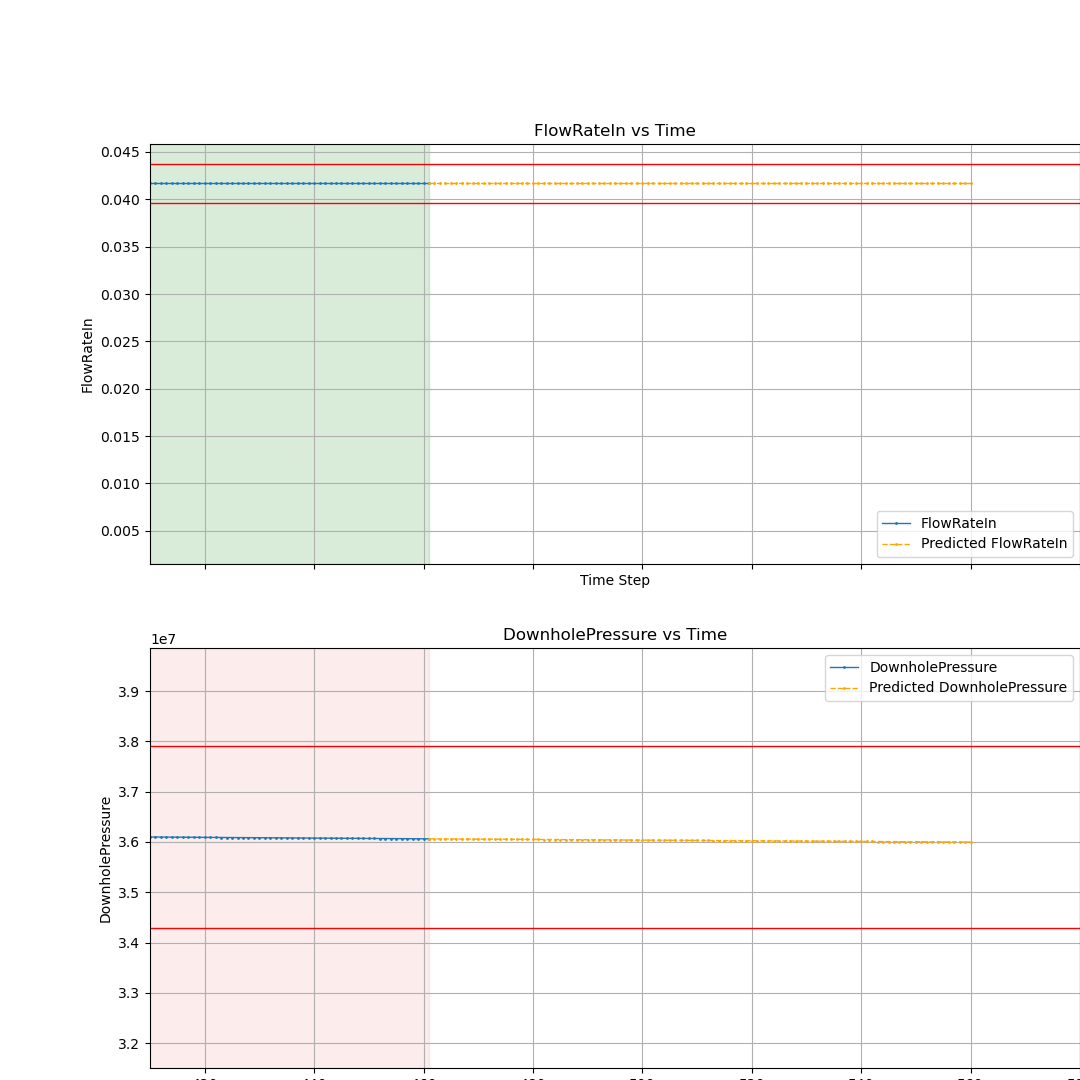

['ActivePitDensity', 'ActivePitTemperature', 'ActivePitVolume', 'FlowRateIn', 'FlowRateOut', 'FluidTemperatureIn', 'FluidTemperatureOut', 'MainPitDensity', 'DownholePressure', 'MainPitTemperature', 'MainPitVolume', 'ReservePitDensity', 'SPP', 'TotalInfluxMass']
Please enter the name of the target column: FlowRateIn
Please enter the name of the optional column: DownholePressure
An anomaly has been detected for FlowRateIn (average percentage change: 100.00%), do you want to continue?y
An anomaly has been detected for FlowRateIn (average percentage change: 16.03%), do you want to continue?y
An anomaly has been detected for FlowRateIn (average percentage change: 5.54%), do you want to continue?y
DownholePressure prediction broke the threshold.
Enter your decision: y


In [ ]:
if __name__ == "__main__":
    main()